In [12]:
import pandas as pd
import os
import sklearn
from sklearn.metrics import roc_curve,auc,precision_recall_curve
import numpy as np
import scipy
import scipy.stats as st
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import seaborn as sns
import pandas as pd
import numpy as np


In [13]:
models = ["iwae","medgan","medbgan","emrwgan","medwgan","dpgan"]

# Model trained and tested on real data

In [14]:
NUM_BOOTSTRAPS = 1000
SIZE_BOOTSTRAPS = 10000

In [15]:
r_70_r_30 = np.load("r_70_train_r_30_test_y_estimate.npy")
r_70_r_30 = pd.DataFrame(r_70_r_30, columns = ["prediction"])
r_30_r_70 = np.load("r_30_train_r_70_test_y_estimate.npy")
r_30_r_70 = pd.DataFrame(r_30_r_70, columns = ["prediction"])
r_70_gs = np.load("r_30_train_r_70_test_y_label.npy")
r_30_gs = np.load("r_70_train_r_30_test_y_label.npy")
r_30_gs = pd.DataFrame(r_30_gs, columns = ["gs"])
r_70_gs = pd.DataFrame(r_70_gs, columns = ["gs"])

In [24]:
def bootstrap_submission_r_train_r_test(prediction, gs):
    score = []
    data = pd.concat([prediction, gs],axis=1)
    for boot in range(NUM_BOOTSTRAPS):
        temp = {}
        sampled_data = data.sample(n=SIZE_BOOTSTRAPS, replace=True)
        fpr, tpr, thresholds = roc_curve(sampled_data["gs"], sampled_data["prediction"], pos_label=1)
        auroc_score = round(auc(fpr, tpr), 4)
        #print (boot, auroc_score)
        score.append(auroc_score)
    lower_p = 2.5
    upper_p =97.5
    mean = round(sum(score) / len(score),3)
    low = round(np.percentile(score,lower_p),3)
    up = round(np.percentile(score,upper_p),3)    
    print(f" {mean}({low},{up})")
    return score

In [25]:
# train on 30% real data and test on 70% real data
real_score_30_70 = bootstrap_submission_r_train_r_test(r_30_r_70, r_70_gs)
# train on 70% real data and test on 30% real data
real_score_70_30 = bootstrap_submission_r_train_r_test(r_70_r_30, r_30_gs)

 0.781(0.756,0.805)
 0.801(0.775,0.824)


In [20]:
fpr, tpr, thresholds = roc_curve(r_30_gs,r_70_r_30, pos_label=1)
auroc_score = round(auc(fpr, tpr), 4)
print(f"Performance of model trained on 70% real data and tested on 30% real data: {auroc_score} ")

fpr, tpr, thresholds = roc_curve(r_70_gs,r_30_r_70, pos_label=1)
auroc_score = round(auc(fpr, tpr), 4)
print(f"Performance of model trained on 30% real data and tested on 70% real data: {auroc_score} ")

Performance of model trained on 70% real data and tested on 30% real data: 0.8014 
Performance of model trained on 30% real data and tested on 70% real data: 0.7807 


In [28]:
len(real_score_70_30)

1000

# Model trained on synthetic data and tested on 30% real data

In [44]:
NUM_BOOTSTRAPS = 1000
SIZE_BOOTSTRAPS = 10000
# medgan_s_train_r_30_test_y_estimate.npy
# medgan_r_30_train_s_test_y_estimate.npy
# train_type s_train_r_30_test, r_30_train_s_test
#{model}_{train_type}_y_estimate.npy
def bootstrap_submission_s_train_r_30_test(model):
    scores = []
    #print (predictions)
    prediction = np.load(f"{model}_s_train_r_30_test_y_estimate.npy").T
    prediction = pd.DataFrame(prediction, columns = ["1","2","3"])
    r_30_gs = np.load("r_70_train_r_30_test_y_label.npy")
    r_30_gs = pd.DataFrame(r_30_gs, columns = ["gs"])
    data = pd.concat([prediction, r_30_gs],axis=1)
    for boot in range(NUM_BOOTSTRAPS):
        for i in range(1,4):
            temp = {}
            sampled_data = data[[str(i),"gs"]].sample(n=SIZE_BOOTSTRAPS, replace=True)
            fpr, tpr, thresholds = roc_curve(sampled_data["gs"], sampled_data[str(i)], pos_label=1)
            auroc_score = round(auc(fpr, tpr), 4)
            #print (boot, auroc_score)
            temp["Model"] = model
            temp["Run"] = i
            temp["AUROC"] = float(auroc_score)
            scores.append(temp)
    scores = pd.DataFrame(scores)
    return scores

In [45]:
res = pd.DataFrame()
for model in models:
    new = bootstrap_submission_s_train_r_30_test(model)
    res = pd.concat([res,new],axis = 0)

In [46]:
name_format = {"emrwgan":"EMR-WGAN", "medgan":"medGAN", "medbgan":"medBGAN","medwgan":"medWGAN","dpgan":"DPGAN","iwae":"IWAE"}
res["Model"] = res["Model"].apply(lambda x: x.replace(x, name_format[x]))
res

,Model,Run,AUROC
0,IWAE,1,0.5502
1,IWAE,2,0.5746
2,IWAE,3,0.4542
3,IWAE,1,0.5770
4,IWAE,2,0.5664
...,...,...,...
2995,DPGAN,2,0.6943
2996,DPGAN,3,0.7047
2997,DPGAN,1,0.6423
2998,DPGAN,2,0.6735


In [47]:
# get 95% CI of each model each run
CI = pd.DataFrame()
for model in name_format.values():
    for run in range(1,4):
        score_l = list(res[(res["Model"] == model)&(res["Run"] == run)]["AUROC"])
        mean = round(sum(score_l) / len(score_l),3)
        lower_p = 2.5
        upper_p =97.5
        low = round(np.percentile(score_l,lower_p),3)
        up = round(np.percentile(score_l,upper_p),3)
        
        print(f"{model}, run {run}: {mean}({low},{up})")

EMR-WGAN, run 1: 0.717(0.691,0.741)
EMR-WGAN, run 2: 0.738(0.709,0.766)
EMR-WGAN, run 3: 0.699(0.67,0.725)
medGAN, run 1: 0.688(0.659,0.717)
medGAN, run 2: 0.563(0.532,0.593)
medGAN, run 3: 0.671(0.643,0.698)
medBGAN, run 1: 0.568(0.538,0.599)
medBGAN, run 2: 0.559(0.529,0.589)
medBGAN, run 3: 0.664(0.638,0.692)
medWGAN, run 1: 0.639(0.61,0.667)
medWGAN, run 2: 0.655(0.628,0.681)
medWGAN, run 3: 0.711(0.684,0.738)
DPGAN, run 1: 0.64(0.611,0.669)
DPGAN, run 2: 0.688(0.662,0.717)
DPGAN, run 3: 0.663(0.635,0.691)
IWAE, run 1: 0.574(0.545,0.602)
IWAE, run 2: 0.568(0.539,0.597)
IWAE, run 3: 0.472(0.442,0.502)


In [48]:
# get 95% CI of each model
CI = pd.DataFrame()
for model in name_format.values():
    score_l = list(res[(res["Model"] == model)]["AUROC"])
    lower_p = 2.5
    upper_p =97.5
    mean = round(sum(score_l) / len(score_l),3)
    low = round(np.percentile(score_l,lower_p),3)
    up = round(np.percentile(score_l,upper_p),3)

    print(f"{model}, run {run}: {mean}({low},{up})")

EMR-WGAN, run 3: 0.718(0.678,0.758)
medGAN, run 3: 0.641(0.541,0.709)
medBGAN, run 3: 0.597(0.534,0.685)
medWGAN, run 3: 0.668(0.618,0.733)
DPGAN, run 3: 0.664(0.619,0.708)
IWAE, run 3: 0.538(0.45,0.597)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

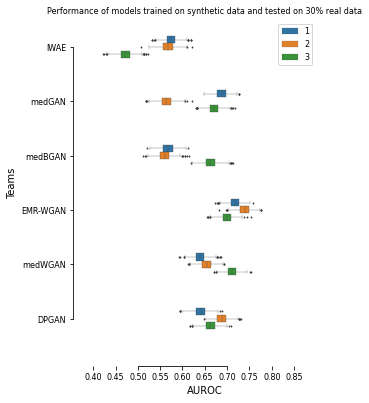

In [34]:
plt.figure()
## plot model performance on different dataset version
plt.figure(figsize=(4,6))
y = np.arange(1,20)
x = np.arange(1,5)
#sns.set(font_scale = 3)
ax = sns.boxplot(x='AUROC',y='Model',hue='Run', data = res, fliersize=1,linewidth = 0.3,width=0.4 )
sns.despine(offset=20, trim=True)
#ax = sns.swarmplot(x='Team', y='AUROC',hue='measurement_group', data = score_list[0],color="grey",size =2)
#ax = sns.scatterplot(x='bin', y='rt_mean',color="red", data = rt_mean)
plt.ylabel('Teams',size=10)
plt.xlabel('AUROC',size=10)
plt.legend(prop={'size':8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(np.arange(0.4,0.9,0.05))
plt.xlim(0.4,0.90)
plt.title('Performance of models trained on synthetic data and tested on 30% real data',size=8 )
plt.savefig('./s_train_r_30_test.eps',bbox_inches='tight', format='eps')   

In [49]:
## special plot for the amia abstract submission, only takes the first run
res_1 = res[res["Run"] ==1]
# real_score_70_30
real_result = pd.DataFrame(real_score_70_30,columns = ["AUROC"])
#real_result[]
real_result["Model"] = "Real"
real_result["Data type"] = "Real"
res_1["Data type"] = "Synthetic"
res_1.drop(columns = ["Run"],inplace = True)
res_1 = pd.concat([res_1,real_result],axis=0)
res_1

/data/users/yanyao/myproj/synpuf/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/data/users/yanyao/myproj/synpuf/venv/lib64/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Model,AUROC,Data type
0,IWAE,0.5502,Synthetic
3,IWAE,0.5770,Synthetic
6,IWAE,0.5625,Synthetic
9,IWAE,0.5811,Synthetic
12,IWAE,0.5703,Synthetic
...,...,...,...
995,Real,0.7997,Real
996,Real,0.7865,Real
997,Real,0.8147,Real
998,Real,0.8048,Real


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

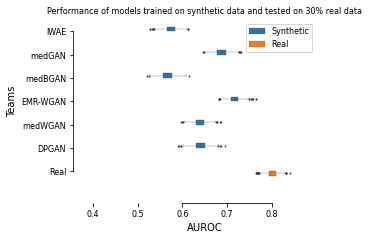

In [52]:
plt.figure()
## plot model performance on different dataset version
plt.figure(figsize=(4,3))
y = np.arange(1,20)
x = np.arange(1,5)
#sns.set(font_scale = 3)
ax = sns.boxplot(x='AUROC',y='Model', data = res_1,hue="Data type", fliersize=1,linewidth = 0.3,width=0.4 )
sns.despine(offset=20, trim=True)
plt.ylabel('Teams',size=10)
plt.xlabel('AUROC',size=10)
plt.legend(prop={'size':8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(np.arange(0.4,0.9,0.1))
plt.xlim(0.4,0.90)
plt.title('Performance of models trained on synthetic data and tested on 30% real data',size=8 )
plt.savefig('./s_train_r_30_test_amia.eps',bbox_inches='tight', format='eps')   

# Model trained on 30% real data and tested on synthetic data

In [53]:
NUM_BOOTSTRAPS = 1000
SIZE_BOOTSTRAPS = 10000
# medgan_r_30_train_s_test_label_gt.npy
# medgan_r_30_train_s_test_y_estimate.npy
def bootstrap_submission_r_30_train_s_test(model):
    scores = []
    #print (predictions)
    prediction = np.load(f"{model}_r_30_train_s_test_y_estimate.npy").T
    prediction = pd.DataFrame(prediction, columns = ["p_1","p_2","p_3"])
    gs = np.load(f"{model}_r_30_train_s_test_label_gt.npy").T
    gs = pd.DataFrame(gs, columns = ["gs_1","gs_2","gs_3"])
    data = pd.concat([prediction, gs],axis=1)
    for boot in range(NUM_BOOTSTRAPS):
        for i in range(1,4):
            temp = {}
            sampled_data = data[[f"gs_{i}",f"p_{i}"]].sample(n=SIZE_BOOTSTRAPS, replace=True)
            fpr, tpr, thresholds = roc_curve(sampled_data[f"gs_{i}"], sampled_data[f"p_{i}"], pos_label=1)
            auroc_score = round(auc(fpr, tpr), 4)
            #print (boot, auroc_score)
            temp["Model"] = model
            temp["Run"] = i
            temp["AUROC"] = float(auroc_score)
            scores.append(temp)
    scores = pd.DataFrame(scores)
    return scores


In [54]:
res = pd.DataFrame()
for model in models:
    new = bootstrap_submission_r_30_train_s_test(model)
    res = pd.concat([res,new],axis = 0)

In [55]:
name_format = {"emrwgan":"EMR-WGAN", "medgan":"medGAN", "medbgan":"medBGAN","medwgan":"medWGAN","dpgan":"DPGAN","iwae":"IWAE"}
res["Model"] = res["Model"].apply(lambda x: x.replace(x, name_format[x]))
res

,Model,Run,AUROC
0,IWAE,1,0.5168
1,IWAE,2,0.5113
2,IWAE,3,0.5040
3,IWAE,1,0.4909
4,IWAE,2,0.5131
...,...,...,...
2995,DPGAN,2,0.5995
2996,DPGAN,3,0.4859
2997,DPGAN,1,0.4613
2998,DPGAN,2,0.6010


In [56]:
# get 95% CI of each model each run
CI = pd.DataFrame()
for model in name_format.values():
    for run in range(1,4):
        score_l = list(res[(res["Model"] == model)&(res["Run"] == run)]["AUROC"])
        lower_p = 2.5
        upper_p =97.5
        low = round(np.percentile(score_l,lower_p),3)
        up = round(np.percentile(score_l,upper_p),3)
        mean = round(sum(score_l) / len(score_l),3)
        print(f"{model}, run {run}: {mean}({low},{up})")

EMR-WGAN, run 1: 0.697(0.669,0.723)
EMR-WGAN, run 2: 0.732(0.704,0.757)
EMR-WGAN, run 3: 0.638(0.612,0.666)
medGAN, run 1: 0.704(0.679,0.728)
medGAN, run 2: 0.516(0.483,0.546)
medGAN, run 3: 0.7(0.672,0.728)
medBGAN, run 1: 0.528(0.499,0.561)
medBGAN, run 2: 0.542(0.516,0.568)
medBGAN, run 3: 0.624(0.59,0.655)
medWGAN, run 1: 0.595(0.564,0.625)
medWGAN, run 2: 0.61(0.581,0.639)
medWGAN, run 3: 0.672(0.643,0.704)
DPGAN, run 1: 0.453(0.424,0.483)
DPGAN, run 2: 0.586(0.558,0.614)
DPGAN, run 3: 0.501(0.473,0.53)
IWAE, run 1: 0.512(0.484,0.541)
IWAE, run 2: 0.501(0.472,0.531)
IWAE, run 3: 0.509(0.479,0.538)


In [57]:
CI = pd.DataFrame()
for model in name_format.values():
    score_l = list(res[(res["Model"] == model)]["AUROC"])
    lower_p = 2.5
    upper_p =97.5
    low = round(np.percentile(score_l,lower_p),3)
    up = round(np.percentile(score_l,upper_p),3)

    mean = round(sum(score_l) / len(score_l),3)
    print(f"{model}, run {run}: {mean}({low},{up})")

EMR-WGAN, run 3: 0.689(0.616,0.751)
medGAN, run 3: 0.64(0.492,0.727)
medBGAN, run 3: 0.565(0.506,0.646)
medWGAN, run 3: 0.626(0.571,0.695)
DPGAN, run 3: 0.513(0.433,0.607)
IWAE, run 3: 0.508(0.476,0.538)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

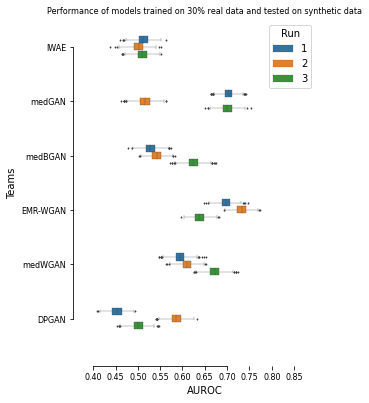

In [60]:
plt.figure()
## plot model performance on different dataset version
plt.figure(figsize=(4,6))
y = np.arange(1,20)
x = np.arange(1,5)
#sns.set(font_scale = 3)
ax = sns.boxplot(x='AUROC',y='Model',hue='Run', data = res, fliersize=1,linewidth = 0.3,width=0.4 )
sns.despine(offset=20, trim=True)
#ax = sns.swarmplot(x='Team', y='AUROC',hue='measurement_group', data = score_list[0],color="grey",size =2)
#ax = sns.scatterplot(x='bin', y='rt_mean',color="red", data = rt_mean)
plt.ylabel('Teams',size=10)
plt.xlabel('AUROC',size=10)
#plt.legend(prop={'size':8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(np.arange(0.4,0.9,0.05))
plt.xlim(0.4,0.90)
plt.title('Performance of models trained on 30% real data and tested on synthetic data',size=8 )
plt.savefig('./r_30_train_s_test.eps',bbox_inches='tight', format='eps')   

In [61]:
## special plot for the amia abstract submission, only takes the first run
res_1 = res[res["Run"] ==1]
# real_score_30_70
real_result = pd.DataFrame(real_score_30_70,columns = ["AUROC"])
real_result["Model"] = "Real"
real_result["Data type"] = "Real"
res_1["Data type"] = "Synthetic"
res_1.drop(columns = ["Run"],inplace = True)
res_1 = pd.concat([res_1,real_result],axis=0)
res_1

/data/users/yanyao/myproj/synpuf/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/data/users/yanyao/myproj/synpuf/venv/lib64/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Model,AUROC,Data type
0,IWAE,0.5168,Synthetic
3,IWAE,0.4909,Synthetic
6,IWAE,0.5210,Synthetic
9,IWAE,0.5201,Synthetic
12,IWAE,0.5103,Synthetic
...,...,...,...
995,Real,0.7946,Real
996,Real,0.7856,Real
997,Real,0.7823,Real
998,Real,0.7767,Real


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

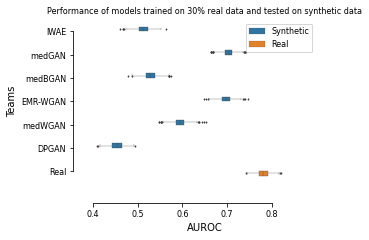

In [64]:
plt.figure()
## plot model performance on different dataset version
plt.figure(figsize=(4,3))
y = np.arange(1,20)
x = np.arange(1,5)
#sns.set(font_scale = 3)
ax = sns.boxplot(x='AUROC',y='Model', data = res_1,hue="Data type", fliersize=1,linewidth = 0.3,width=0.4 )
sns.despine(offset=20, trim=True)
#ax = sns.swarmplot(x='Team', y='AUROC',hue='measurement_group', data = score_list[0],color="grey",size =2)
#ax = sns.scatterplot(x='bin', y='rt_mean',color="red", data = rt_mean)
plt.ylabel('Teams',size=10)
plt.xlabel('AUROC',size=10)
plt.legend(prop={'size':8})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(np.arange(0.4,0.9,0.1))
plt.xlim(0.4,0.90)
plt.title('Performance of models trained on 30% real data and tested on synthetic data',size=8 )
plt.savefig('./r_30_train_s_test_amia.eps',bbox_inches='tight', format='eps')   